In [1]:
# load data
import pandas as pd

df = pd.read_csv("./gender-classifier-DFE-791531.csv", encoding="latin1")
print(df.columns)


Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')


In [2]:
# select relevant columns
df = pd.concat([df.gender, df.description, df.text], axis = 1)

# remove NaN values
df.dropna(axis=0, inplace=True)

# reduced dataset for testing purposes
# df.drop(df.index[1000:], inplace=True)

n, d = df.shape
print(df)


       gender                                        description  \
0        male                              i sing my own rhythm.   
1        male  I'm the author of novels filled with family dr...   
2        male                louis whining and squealing and all   
3        male  Mobile guy.  49ers, Shazam, Google, Kleiner Pe...   
4      female  Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...   
...       ...                                                ...   
20045  female                                               (rp)   
20046    male  Whatever you like, it's not a problem at all. ...   
20047    male  #TeamBarcelona ..You look lost so you should f...   
20048  female  Anti-statist; I homeschool my kids. Aspiring t...   
20049  female                     Teamwork makes the dream work.   

                                                    text  
0      Robbie E Responds To Critics After Win Against...  
1      ÛÏIt felt like they were my friends and I was...  
2     

In [3]:
# tokenize and return lemmatized message
import spacy
nlp = spacy.load("en_core_web_sm")

def tokenize_lemmatize(msg):
    doc = nlp(msg)
    tmp = []
    for token in doc:
        tmp.append(token.lemma_)
    return " ".join(tmp)


In [4]:
# tokenize and lemmatize
for i in df.index:
    df["description"][i] = tokenize_lemmatize(df["description"][i])
    df["text"][i] = tokenize_lemmatize(df["text"][i])


In [6]:
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer

data = df[["description", "text"]]

vect = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
transformer = make_column_transformer((vect, "description"), (vect, "text"))

x = transformer.fit_transform(data).toarray()
y = df["gender"]

print(x.shape)


(16224, 275044)


In [7]:
# split for train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

print(x_train.shape)
print(x_test.shape)


(14601, 275044)
(1623, 275044)


In [8]:
# 3-fold cross validation
# from sklearn.model_selection import cross_validate
# from sklearn.naive_bayes import GaussianNB

# gnb = GaussianNB()
# scores = cross_validate(gnb, x_train, y_train, cv=3, scoring=["accuracy", "precision_weighted", "recall_weighted"])


In [9]:
# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
scores = cross_validate(gnb, x_train, y_train, scoring=["accuracy", "precision_weighted", "recall_weighted"])


In [10]:
print(scores.keys())


dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision_weighted', 'test_recall_weighted'])


In [13]:
# print metrics
acc = scores["test_accuracy"]
print("accuracy:", acc)
print("avg accuracy:", sum(acc) / 5)
prec = scores["test_precision_weighted"]
print("precision:", prec)
print("avg precision:", sum(prec) / 5)
rec = scores["test_recall_weighted"]
print("recall:", rec)
print("avg recall:", sum(rec) / 5)


accuracy: [0.49982883 0.50616438 0.49452055 0.4869863  0.475     ]
avg accuracy: 0.49250001172426405
precision: [0.4929085  0.50046313 0.48690221 0.48090488 0.469231  ]
avg precision: 0.48608194480877354
recall: [0.49982883 0.50616438 0.49452055 0.4869863  0.475     ]
avg recall: 0.49250001172426405


In [14]:
# test model
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)


In [15]:
# display metrics
import matplotlib.pyplot as plt
from sklearn import metrics

# print the accuracy, f1, confusion matrix, precision, recall
def display_metrics(y, y_pred):
    lbl = ["male", "female", "brand"]
    
    print("accuracy:", metrics.accuracy_score(y, y_pred))
    prec_rec = metrics.precision_recall_fscore_support(y, y_pred, labels=lbl, average="weighted")
    print("precision:", prec_rec[0])
    print("recall:", prec_rec[1])

    metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=lbl, normalize='true')
    plt.show()


accuracy: 0.4849044978434997
precision: 0.49307311620669075
recall: 0.5091145833333334


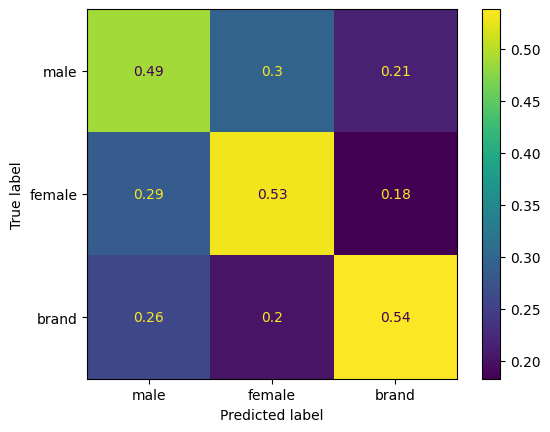

In [16]:
# display metrics
display_metrics(y_test, y_pred)
